In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 加载数据
path1 = r""#数据所在路径
datas1 = pd.DataFrame(pd.read_csv(path1))
data1=datas1.interpolate()
values1 = data1.values
print(data1.head())
print(data1.shape)

        Temp   Humidity       GHI       DHI  Rainfall  Power
0  19.779453  40.025826  3.232706  1.690531       0.0    0.0
1  19.714937  39.605961  3.194991  1.576346       0.0    0.0
2  19.549330  39.608631  3.070866  1.576157       0.0    0.0
3  19.405870  39.680702  3.038623  1.482489       0.0    0.0
4  19.387363  39.319881  2.656474  1.134153       0.0    0.0
(104256, 6)


In [3]:
data1

Temp   Humidity       GHI       DHI  Rainfall  Power
0       19.779453  40.025826  3.232706  1.690531       0.0    0.0
1       19.714937  39.605961  3.194991  1.576346       0.0    0.0
2       19.549330  39.608631  3.070866  1.576157       0.0    0.0
3       19.405870  39.680702  3.038623  1.482489       0.0    0.0
4       19.387363  39.319881  2.656474  1.134153       0.0    0.0
...           ...        ...       ...       ...       ...    ...
104251  13.303740  34.212711  1.210789  0.787026       0.0    0.0
104252  13.120920  34.394939  2.142980  1.582670       0.0    0.0
104253  12.879215  35.167400  1.926214  1.545889       0.0    0.0
104254  12.915867  35.359989  1.317695  0.851529       0.0    0.0
104255  13.134816  34.500034  1.043269  0.597816       0.0    0.0

[104256 rows x 6 columns]

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD, EEMD, CEEMDAN
import warnings
warnings.filterwarnings('ignore')



class ICEEMDAN:
    """
    ICEEMDAN (Improved Complete Ensemble Empirical Mode Decomposition with Adaptive Noise)
    """
    
    def __init__(self, I=50, epsilon_0=0.2, max_imf=16):
        """
        初始化ICEEMDAN分解器
        
        参数:
        - I: 白噪声实现次数
        - epsilon_0: 初始信噪比
        - max_imf: 最大IMF数量
        """
        self.I = I
        self.epsilon_0 = epsilon_0
        self.max_imf = max_imf
        
        # 初始化EMD对象
        self.emd = EMD()
        self.emd.trials = 1  # 单次运行
        
    def _generate_noise_modes(self, length, num_modes):
        """
        生成白噪声的EMD模态
        
        参数:
        - length: 信号长度
        - num_modes: 需要的模态数量
        
        返回:
        - noise_modes: 白噪声的各阶模态
        """
        noise_modes = []
        
        for i in range(self.I):
            # 生成白噪声
            white_noise = np.random.normal(0, 1, length)
            
            # EMD分解白噪声
            try:
                noise_imfs = self.emd.emd(white_noise, max_imf=num_modes)
                
                # 确保有足够的模态
                if len(noise_imfs) < num_modes:
                    # 用零填充不足的模态
                    for _ in range(num_modes - len(noise_imfs)):
                        noise_imfs = np.vstack([noise_imfs, np.zeros(length)])
                
                noise_modes.append(noise_imfs[:num_modes])
            except:
                # 如果EMD失败，创建零模态
                noise_modes.append(np.zeros((num_modes, length)))
        
        return noise_modes
    
    def iceemdan(self, data):
        """
        执行ICEEMDAN分解
        
        参数:
        - data: 输入时间序列
        
        返回:
        - imfs: IMF分量数组
        - residue: 最终残差
        """
        N = len(data)
        data_std = np.std(data)
        
        # 初始化
        imfs = []
        
        # 步骤1: 计算初始残差 r1
        # r1 = (1/I) * Σ M(x + ε0 * ω^(i))
        print("步骤1: 计算初始残差...")
        
        r1_ensemble = []
        for i in range(self.I):
            # 生成白噪声
            noise = np.random.normal(0, 1, N)
            
            # 向原始信号注入噪声
            noisy_signal = data + self.epsilon_0 * data_std * noise
            
            # EMD分解，只取第一个IMF
            try:
                temp_imfs = self.emd.emd(noisy_signal, max_imf=1)
                if len(temp_imfs) > 0:
                    # 残差 = 原始信号 - 第一个IMF
                    r1_ensemble.append(noisy_signal - temp_imfs[0])
                else:
                    r1_ensemble.append(noisy_signal)
            except:
                r1_ensemble.append(noisy_signal)
        
        # 计算r1的均值
        r1 = np.mean(r1_ensemble, axis=0)
        
        # 步骤2: 计算第一个IMF
        # IMF1 = x - r1
        imf1 = data - r1
        imfs.append(imf1)
        
        print(f"提取IMF1完成")
        
        # 步骤3: 计算高阶残差和IMF
        r_k = r1.copy()
        
        for k in range(1, self.max_imf):
            print(f"步骤3: 计算IMF{k+1}...")
            
            # 检查残差是否可以继续分解
            if self._check_termination(r_k):
                break
            
            # 生成第k阶噪声模态
            noise_modes = self._generate_noise_modes(N, k)
            
            # 计算第k阶残差
            # rk = (1/I) * Σ M(r_{k-1} + ε_{k-1} * E_k(ω^(i)))
            rk_ensemble = []
            epsilon_k = self.epsilon_0 * (0.8 ** k)  # 自适应信噪比衰减
            
            for i in range(self.I):
                # 获取第k阶噪声模态
                if len(noise_modes[i]) >= k:
                    E_k = noise_modes[i][k-1]  # 第k个模态（索引k-1）
                else:
                    E_k = np.zeros(N)
                
                # 向前一阶残差注入噪声
                noisy_residue = r_k + epsilon_k * data_std * E_k
                
                # EMD分解，只取第一个IMF
                try:
                    temp_imfs = self.emd.emd(noisy_residue, max_imf=1)
                    if len(temp_imfs) > 0:
                        rk_ensemble.append(noisy_residue - temp_imfs[0])
                    else:
                        rk_ensemble.append(noisy_residue)
                except:
                    rk_ensemble.append(noisy_residue)
            
            # 计算rk的均值
            r_k_new = np.mean(rk_ensemble, axis=0)
            
            # 计算第k+1个IMF
            # IMF_{k+1} = r_k - r_{k+1}
            imf_k = r_k - r_k_new
            imfs.append(imf_k)
            
            print(f"提取IMF{k+1}完成")
            
            # 更新残差
            r_k = r_k_new
            
            # 检查残差的能量
            if np.var(r_k) < 1e-10:
                break
        
        # 最终残差
        residue = r_k
        
        # 转换为numpy数组
        imfs_array = np.column_stack(imfs)
        
        return imfs_array, residue
    
    def _check_termination(self, signal):
        """
        检查信号是否应该终止分解
        当极值点数量少于3个时终止
        """
        diff = np.diff(signal)
        sign_changes = np.diff(np.sign(diff))
        extrema_count = np.sum(np.abs(sign_changes) > 1)
        
        return extrema_count < 3

# =============================================================================
# 3. 滑动窗口实现（避免未来信息）
# =============================================================================

def sliding_window_iceemdan(data, window_size, step_size=None, I=50, epsilon_0=0.2):
    """
    滑动窗口ICEEMDAN分解，避免引入未来信息
    
    参数:
    - data: 输入时间序列
    - window_size: 窗口大小
    - step_size: 步长（如果为None，则等于window_size，即无重叠）
    - I: 白噪声实现次数
    - epsilon_0: 初始信噪比
    
    返回:
    - all_imfs: 所有IMF的拼接结果
    - all_residues: 所有残差的拼接结果
    """
    if step_size is None:
        step_size = window_size
    
    N = len(data)
    iceemdan_obj = ICEEMDAN(I=I, epsilon_0=epsilon_0) # 使用您的自定义类
    
    all_imfs = []
    all_residues = []
    
    print(f"开始滑动窗口处理，窗口大小: {window_size}, 步长: {step_size}")
    
    window_count = 0
    for start_idx in range(0, N, step_size):
        end_idx = min(start_idx + window_size, N)
        
        # 如果窗口太小，跳过
        if end_idx - start_idx < 100:
            continue
        
        window_count += 1
        
        # 提取当前窗口数据
        window_data = data[start_idx:end_idx]
        
        print(f"处理窗口 {window_count}: 索引 {start_idx}-{end_idx-1}")
        
        # ICEEMDAN分解
        try:
            imfs, residue = iceemdan_obj.iceemdan(window_data) # 调用自定义ICEEMDAN类的分解方法
            
            # 存储结果
            all_imfs.append(imfs)
            all_residues.append(residue)
            
            print(f"窗口 {window_count} 完成，得到 {imfs.shape[1]} 个IMF")
            
        except Exception as e:
            print(f"窗口 {window_count} 处理失败: {e}")
            continue
    
    # 拼接所有结果
    if all_imfs:
        # 确保所有IMF有相同的列数 (因为每个窗口可能产生不同数量的IMF)
        # 找到最大IMF数量
        max_imfs = 0
        for imf_arr in all_imfs:
            if imf_arr.shape[1] > max_imfs:
                max_imfs = imf_arr.shape[1]

        standardized_imfs = []
        for imf_arr in all_imfs:
            if imf_arr.shape[1] < max_imfs:
                # 用零填充缺失的IMF
                padding = np.zeros((imf_arr.shape[0], max_imfs - imf_arr.shape[1]))
                imf_arr = np.hstack([imf_arr, padding])
            standardized_imfs.append(imf_arr)
        
        final_imfs = np.vstack(standardized_imfs)
        final_residues = np.concatenate(all_residues)
        
        return final_imfs, final_residues
    else:
        return np.array([]), np.array([])

# =============================================================================
# 4. 主处理流程
# =============================================================================

data_power = data1['Power'].values

# 参数设置
window_size = len(data_power)   # 窗口大小等于数据长度，对整个数据进行分解
I = 50                          # 白噪声实现次数 
epsilon_0 = 0.2                 # 初始信噪比 

print(f"--- 开始基于PyEMD的ICEEMDAN分解 ---")
print(f"数据长度: {len(data_power)}")
print(f"窗口大小: {window_size}")
print(f"白噪声实现次数: {I}")
print(f"初始信噪比: {epsilon_0}")

# 对整个数据进行ICEEMDAN分解
print("正在执行ICEEMDAN分解...")
iceemdan_obj = ICEEMDAN(I=I, epsilon_0=epsilon_0) # 实例化您的ICEEMDAN类
imfs, residue = iceemdan_obj.iceemdan(data_power) # 调用分解方法

# 检查分解结果是否为空
if imfs.size == 0 and residue.size == 0:
    print("\n分解未成功，未生成任何IMF或残差。请检查输入数据或算法逻辑。")
else:
    print(f"分解完成，得到 {imfs.shape[1]} 个IMF。")
    
    # 创建结果DataFrame
    result_df = pd.DataFrame(imfs, columns=[f'IMF{i+1}' for i in range(imfs.shape[1])])
    result_df['Residue'] = residue
    
    # 计算IMFs总和
    imf_columns = [col for col in result_df.columns if col.startswith('IMF')]
    IMFs_sum = result_df[imf_columns].sum(axis=1) 
    
    # 验证重构精度
    reconstructed_signal = IMFs_sum + result_df['Residue'] 
    
    # 取较短长度进行比较，以防原始数据或重构信号长度不一致
    min_length = min(len(data_power), len(reconstructed_signal))
    reconstruction_error = np.mean(np.abs(reconstructed_signal[:min_length] - data_power[:min_length]))
    
    print(f"\n=== 分解结果概览 ===")
    print(f"原始数据长度: {len(data_power)}")
    print(f"重构数据长度: {len(reconstructed_signal)}")
    print(f"IMF数量: {len(imf_columns)}")
    print(f"重构平均绝对误差 (MAE): {reconstruction_error:.6f}")
    
    if reconstruction_error < 0.1: # 0.1 是一个示例阈值，可根据实际情况调整
        print("重构信号与原始数据基本一致。")
    else:
        print("重构存在一定误差，可能需要调整参数或检查算法实现。")
    
    # 显示结果示例
    print(f"\n=== 分解结果示例 (前5行) ===")
    print(result_df.head())
    
    print(f"\n=== 关键输出预览 ===")
    print(f"IMFs_sum 的形状: {IMFs_sum.shape} - IMF分量的总和")
    print(f"Residue 的形状: {residue.shape} - 最终残差")
    print(f"验证: IMFs_sum + Residue 理论上应精确等于原始信号 (重构信号)。")
    
    # 输出IMFs_sum和residue的前几个值
    print(f"\nIMFs_sum 前10个值:")
    print(IMFs_sum.head(10).values)
    
    print(f"\nResidue 前10个值:")
    print(residue[:10])

--- 开始基于PyEMD的ICEEMDAN分解 ---
数据长度: 104256
窗口大小: 104256
白噪声实现次数: 50
初始信噪比: 0.2
正在执行ICEEMDAN分解...
步骤1: 计算初始残差...
提取IMF1完成
步骤3: 计算IMF2...
提取IMF2完成
步骤3: 计算IMF3...
提取IMF3完成
步骤3: 计算IMF4...
提取IMF4完成
步骤3: 计算IMF5...
提取IMF5完成
步骤3: 计算IMF6...
提取IMF6完成
步骤3: 计算IMF7...
提取IMF7完成
步骤3: 计算IMF8...
提取IMF8完成
步骤3: 计算IMF9...
提取IMF9完成
步骤3: 计算IMF10...
提取IMF10完成
步骤3: 计算IMF11...
提取IMF11完成
步骤3: 计算IMF12...
提取IMF12完成
步骤3: 计算IMF13...
提取IMF13完成
步骤3: 计算IMF14...
提取IMF14完成
步骤3: 计算IMF15...
提取IMF15完成
步骤3: 计算IMF16...
提取IMF16完成
分解完成，得到 16 个IMF。

=== 分解结果概览 ===
原始数据长度: 104256
重构数据长度: 104256
IMF数量: 16
重构平均绝对误差 (MAE): 0.000000
✅ 重构信号与原始数据基本一致。

=== 分解结果示例 (前5行) ===
       IMF1      IMF2      IMF3      IMF4      IMF5      IMF6      IMF7  \
0 -0.033467  0.012384  0.013869 -0.012228 -0.001804 -0.004172 -0.150218   
1 -0.036653  0.019128  0.015302 -0.017329 -0.002215 -0.004333 -0.152708   
2 -0.008793  0.004752 -0.001476 -0.016723 -0.000434 -0.003053 -0.156507   
3  0.007589 -0.007334 -0.020186 -0.006611  0.002865 -0.000723 -0.1614

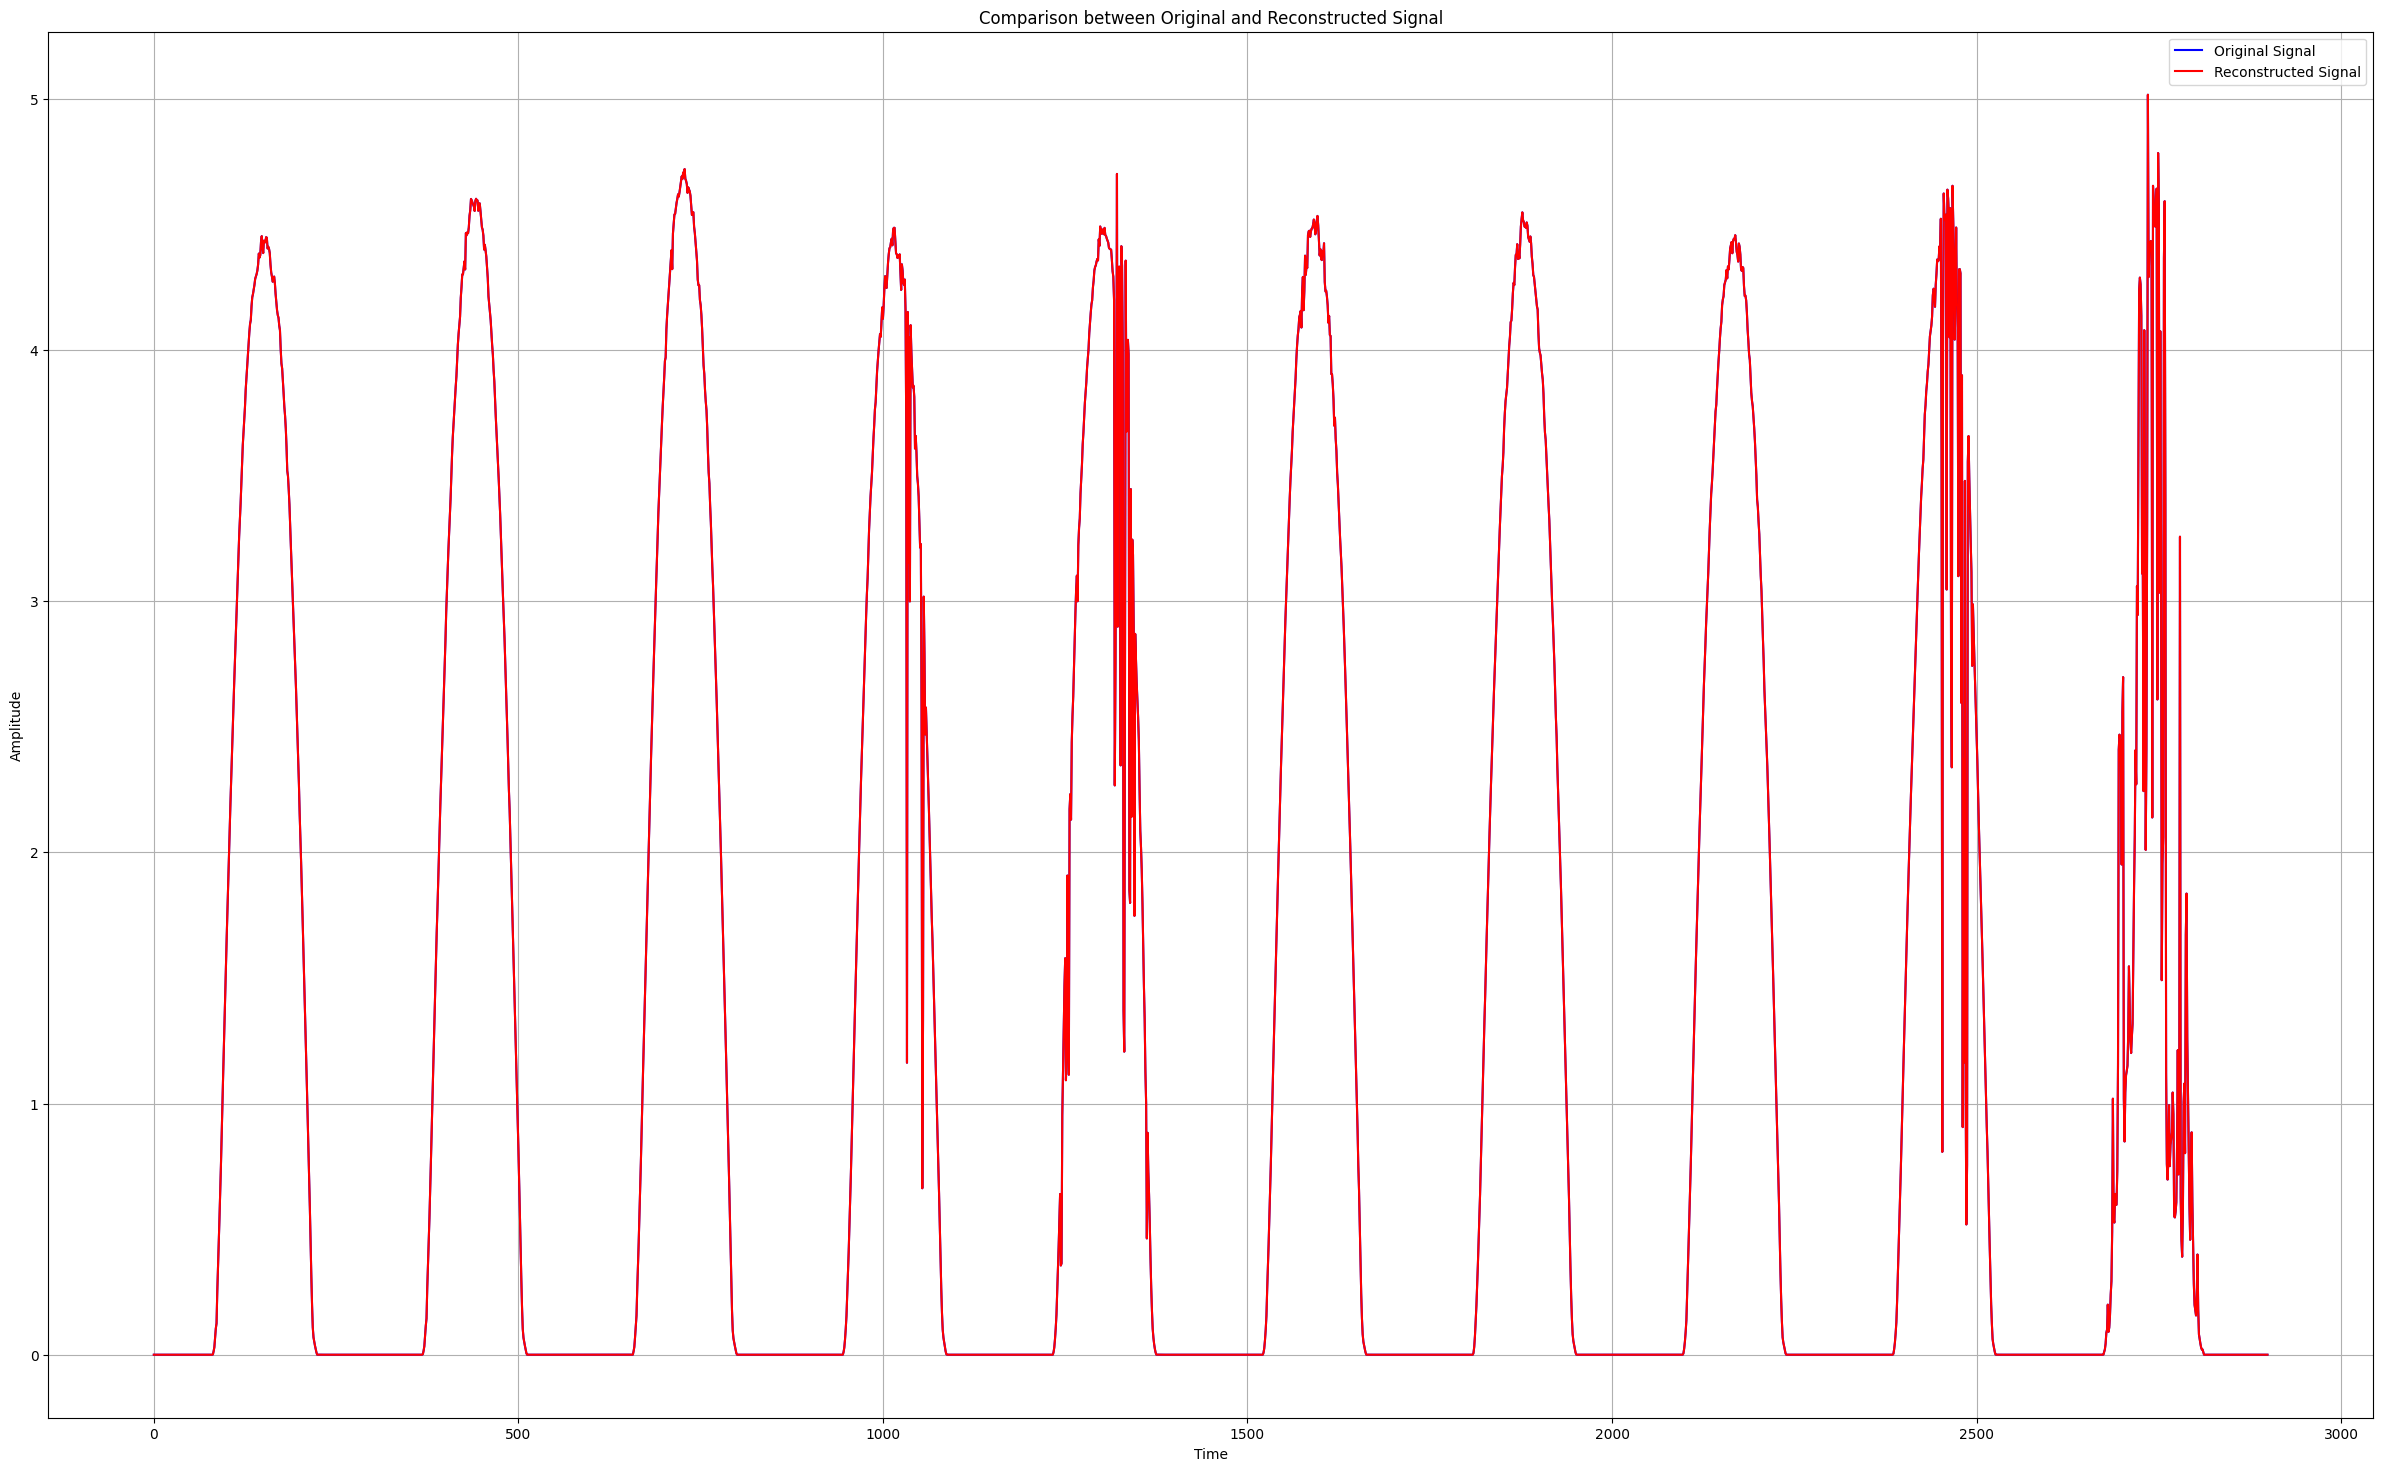

In [35]:
# 将分解后的 IMFs 与残差相加以恢复原始数据
reconstructed_signal = IMFs_sum + residue

# 绘制重构的数据与原始数据进行比较
plt.figure(figsize=(30, 18))
plt.plot(current_data[0:2900], label='Original Signal', color='blue')
plt.plot(reconstructed_signal[0:2900], label='Reconstructed Signal', color='red')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Comparison between Original and Reconstructed Signal')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import matplotlib.pyplot as plt

# 设置全局字体大小
plt.rcParams.update({'font.size': 60})  # 设置字体大小为 16

num_imfs = IMFs.shape[1]

plt.figure(figsize=(64,128))

# 绘制每个 IMF
for i in range(num_imfs):
    if i <= 19:  # 只绘制前 14 个 IMF
        plt.subplot(num_imfs, 1, i + 1)
        plt.plot(data_ICEEMDAN[f'IMF{i}'], label=f'IMF {i}')
        plt.legend()
plt.legend()

# 绘制残差
plt.subplot(num_imfs + 1, 1, num_imfs + 1)
plt.plot(data_ICEEMDAN[f'IMF{17}'], label='Residue', color='red')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_13476\2876220827.py:24: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def plot_frequency_spectrum(signal, sampling_rate, title):
    """
    绘制信号的频谱图。
    
    参数：
    - signal: 输入信号
    - sampling_rate: 信号的采样率
    - title: 图表标题
    """
    f, Pxx = welch(signal, fs=sampling_rate, nperseg=len(signal))
    plt.figure(figsize=(10, 5))
    plt.semilogy(f, Pxx)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density')
    plt.grid(True)
    plt.show()

def compute_zero_crossings(signal):
    """
    计算信号的过零率。
    """
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)
    return zero_crossing_rate

def classify_frequency_component(imfs, threshold):
    """
    将每个 IMF 分为高频和低频成分。
    """
    high_frequency_imfs = []
    low_frequency_imfs = []
    for i in range(imfs.shape[1]):
        imf = imfs[:, i]
        zero_crossing_rate = compute_zero_crossings(imf)
        if zero_crossing_rate > threshold:
            high_frequency_imfs.append(imf)
        else:
            low_frequency_imfs.append(imf)
    return high_frequency_imfs, low_frequency_imfs

# 定义过零率的阈值
threshold = 0.02  

# 根据过零率判断高频和低频成分
high_freq_imfs, low_freq_imfs = classify_frequency_component(IMFs, threshold)
